In [1]:
import os
import numpy as np
import pandas as pd
import utilities_dataset as uta
import re
#Automcompletar rápido
%config IPCompleter.greedy=True

import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer=WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
raiz= "C:/Proyectos/X01_sentiment_analyzer"

path_stopwords = raiz+"/01_Documentos/stopwords.txt"
stopwords = [c.strip() for c in open(path_stopwords)]



datos = uta.load_dataset_train(raiz=raiz)
datos_test = uta.load_dataset_val(raiz=raiz)

In [2]:
Y = datos['sentiment'].copy()
X = datos[['text']].fillna("-").copy()

# CLASES

In [4]:
class Preprocesador_datos:
    def __init__(self,data,variable, stopwords):
        
        self.df_input = data[variable]
        self.output =  None
        self.nombre_final = 'texto'
        self.lista_fcs = [self.feature_weburl]
        self.stopwords = stopwords
        
    def feature_weburl(self,texto:str):
        s = texto.lower().strip()
        ss = re.sub(r"(http|https)\:\/\/\w*\.\w*(\.\w*|\/\w*|~\w*)*(|\/[~\w\d]*|\.w*)", "weburl", s)
        return ss
        
        
    def preproceso_texto(self,texto:str):
            s = texto.lower().strip()
            tokens = nltk.tokenize.word_tokenize(s)
            tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
            tokens = [t for t in tokens if t not in self.stopwords]
            # tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
            return ' '.join(tokens)

    def _add_fc(self,fcs):
        self.lista_fcs.append(fcs)

    def fit(self):
        X = self.df_input.copy()
        self._add_fc(self.preproceso_texto)
        for fc in  self.lista_fcs:
            X = self.apply_fc(X,fc)
        self.output = X
        
    def apply_fc(self, data, fc):
        return data.apply(lambda x: fc(x))
        
    @property
    def datos_procesado(self):
        aux =  pd.DataFrame(self.output)
        aux.columns = [self.nombre_final]
        return aux

In [5]:
class Sentiment_Vectorizer:
    def __init__(self, params_Tfidf=None ):
        self.nombres_variables = None
        self.params_Tfidf = params_Tfidf
        self._get_parameters()
        self.cv = None
        self.num_variables = None
        self.nombres_variables =None
        
    def _get_parameters(self):
        if self.params_Tfidf is None:
            self.params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,             
                         "stop_words": "english",
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300}
            
    def fit_vectorizer(self,data):
        """v1.0"""
        X = data.copy()

        cv=TfidfVectorizer(**self.params_Tfidf)
        cv.fit(X['texto'])
        
        self.nombres_variables = cv.get_feature_names_out().tolist()
        self.num_variables = len(self.nombres_variables)
        self.cv = cv
        return None

    def transform_vectorizer(self, data):
        dfs = self.cv.transform(data["texto"])
        return  pd.DataFrame.sparse.from_spmatrix(dfs,columns = self.nombres_variables  )
        


    def fit_transform_vectorizer(self,data):
        self.fit_vectorizer(data)
        return self.transform_vectorizer( data)


In [6]:
class Sentiment_Evaluator:
    def __init__(self, model, params_model=None):
        
        self.model = model
        self.params_model = params_model
        if params_model is None:
            self.model = self.model()
        else:
            self.model = self.model(**params_model)
        
    def fit(self,train_data,Y, scoring="f1_macro" , cv=10):
        self.results = cross_val_score(self.model,train_data,Y,cv=cv,scoring=scoring)
        self.scoring = scoring 

    
    def print_cv_results(self):
        print("RESULTADOS")
        print("---------------------")
        
        media = np.mean(self.results)
        std = np.std(self.results)
        
        print(f"Metrica {self.scoring} ")
        print(f"media: {media:.3f}")
        print(f"std:{std:.3f}")
        print(f"min:{np.min(self.results):.3f}")
        print(f"max:{np.max(self.results):.3f}")

        

    def mostrar_tabla(self,train_data,Y,test_data=None):
        self.model.fit(train_data,Y)
        
        from sklearn.metrics import ConfusionMatrixDisplay
        
        if test_data is None:
            XX = train_data
        else:
            XX = test_data
            
        ConfusionMatrixDisplay.from_estimator( se_.model, XX, Y, xticks_rotation="vertical" )
        print(classification_report(Y, se_.model.predict(XX)))
    

In [7]:
class New_features_pruebas:
    def __init__(self, data, lista_fcs):
        self.lista_fcs = lista_fcs
        self.data = data
        self.num_datos = len(data)
        self.lista_output = []
        
    def _anadir_fc(self,nombre, fc):
        
        self._check_nombre(nombre)
        self.lista_fcs.append( (nombre,fc))

    def _check_nombre(self,nombre):
        nombre_es_str = isinstance(nombre, str)
        assert nombre_es_str, f"nombre {nombre} tiene que ser string"

        
    def fit(self,nombre, fc):
        self._check_nombre(nombre)
        
        aux = self.data.apply(lambda x: fc(x))
        aux.name = nombre
        return aux
            
    def obtener_variables(self):
        for nombre, fc in self.lista_fcs:
            self.lista_output.append(self.fit(nombre,fc))
        for elemento in self.lista_output:
            assert elemento.size == self.num_datos, f"numero de filas incorrecto, nombre: {elemento.name}"

        df_final = pd.concat(self.lista_output,axis=1)
        return df_final
        

    

# ITERACION 0
F1 MEDIO : 0.625

In [ ]:
preprocesador = Preprocesador_datos(X,"text")
preprocesador.fit()
df_texto = preprocesador.datos_procesado

sv_ = Sentiment_Vectorizer()
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)
N0c = x___.columns
se_ = Sentiment_Evaluator(model = LogisticRegression)
se_.fit(x___,Y)

se_.print_cv_results()

In [16]:
se_.print_cv_results()

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.625
std:0.009
min:0.611
max:0.639


In [18]:
sv_.nombres_variables

['10',
 '30',
 'actually',
 'ago',
 'ah',
 'amazing',
 'anymore',
 'awake',
 'awesome',
 'aww',
 'awww',
 'baby',
 'bad',
 'beautiful',
 'bed',
 'believe',
 'birthday',
 'bit',
 'boo',
 'book',
 'bored',
 'bought',
 'boy',
 'break',
 'broke',
 'brother',
 'busy',
 'buy',
 'called',
 'car',
 'cat',
 'cause',
 'change',
 'check',
 'class',
 'coffee',
 'cold',
 'com',
 'coming',
 'computer',
 'concert',
 'cool',
 'couldn',
 'crazy',
 'cute',
 'dad',
 'day',
 'didn',
 'didnt',
 'dinner',
 'doe',
 'doesn',
 'dog',
 'doing',
 'don',
 'dont',
 'dream',
 'drink',
 'drive',
 'dude',
 'eat',
 'eating',
 'enjoy',
 'evening',
 'exam',
 'excited',
 'eye',
 'facebook',
 'family',
 'fan',
 'favorite',
 'feel',
 'feeling',
 'finally',
 'finished',
 'follow',
 'follower',
 'following',
 'food',
 'forgot',
 'forward',
 'free',
 'friday',
 'friend',
 'fun',
 'funny',
 'game',
 'getting',
 'girl',
 'glad',
 'god',
 'gon',
 'gone',
 'goodnight',
 'guess',
 'guy',
 'ha',
 'haha',
 'hahaha',
 'hair',
 'happy

# ITERACION 1: 
    - BASADO EN ITERACION 0
    
    Procesamento:
    - cambio de palabras (+)
    
    Nuevas caracteristicas:
    - numero_caracteres_especiales
    - grupos_caracteres_especiales
    - numero_palabras_mayusculas
    
Resultados: MAL RESULTADO

In [31]:
def cambio_palabras(texto:str):
    s = texto.lower().strip()
    
    dict_palabras = {'cant':'not','funny':'fun','missed':'miss', 'missing':'miss','watching':'watch','waiting':'wait',
                    'trying':'try', 'twitter':'tweet','haha': 'hahaha','didnt':'not','feeling': 'feel', 'awww':'aww',
                    'mum':'mommy', 'try':'tried','wasn':'not','doesn':'not','didn':'not', 'don':'not','dont':'not'}
    return ' '.join([dict_palabras.get(palabra,palabra) for palabra in s.split()])
    # return  dict_palabras.get(s,s)

In [40]:
def numero_caracteres_especiales(texto:str):
    "cuenta el numero de caracteres especiales"
    ss=re.sub(r"\w*", r"", texto).strip()
    return len(re.sub(r" ",r"",ss))
def grupos_caracteres_especiales(texto:str):
    "grupos de caracteres. los grupos son mas de 2 caracteres especiales"
    ss=re.sub(r"\w*", r"", texto).strip()
    return len(re.findall(r"[?!¡]{2,20}",ss))

def numero_palabras_mayusculas(texto:str):
    return len(re.findall(r"[A-Z]+",texto))

In [ ]:
preprocesador = Preprocesador_datos(X,"text")
preprocesador._add_fc(cambio_palabras)
preprocesador.fit()
df_texto = preprocesador.datos_procesado

nfp = New_features_pruebas(X["text"], [("numero_caracteres_especiales",numero_caracteres_especiales),
                                ("grupos_caracteres_especiales",grupos_caracteres_especiales),
                                ("numero_palabras_mayusculas",numero_palabras_mayusculas) ] )
df_new_features = nfp.obtener_variables()


params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300}

sv_ = Sentiment_Vectorizer(params_Tfidf )
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)

N1c = x___.columns

df_to_train = pd.concat([x___,df_new_features.reset_index()],axis=1).set_index("textID")

se_ = Sentiment_Evaluator(model = LogisticRegression, params_model={"max_iter":1000})
se_.fit(df_to_train,Y)

se_.print_cv_results()

In [66]:
se_.print_cv_results()

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.630
std:0.011
min:0.603
max:0.645


In [88]:
N0_set = set(N0c.tolist())
N1_set = set(N1c.tolist())

In [94]:
def columns_analysis(set1,set2):
    if isinstance(set1,list):
        set1 = set(set1)
    if isinstance(set2,list):
        set2 = set(set2)
        
    string = "Numero de elementos"
    print(f"{string}  set1 {len(set1)}")
    print(f"{string} set2 {len(set2)}")
    print("")
    
    print("Elementos que existen en set1 y no en set2:")
    print(set1.difference(set2))
    print("Elementos que existen en set2 y no en set1:")
    print(set2.difference(set1) )    
    
columns_analysis(N0_set,N1_set)

Numero de elementos  set1 300
Numero de elementos set2 300

Elementos que existen en set1 y no en set2:
{'feeling', 'bought', 'trying', 'didnt', 'awww', 'missed', 'dont', 'mum', 'missing', 'funny', 'watching', 'waiting', 'ice', 'vote', 'link'}
Elementos que existen en set2 y no en set1:
{'call', 'mine', 'else', 'cry', 'if', 'found', 're', 'you', 'then', 'name', 'am', 'please', 'this', 'sometimes', 'own'}


# ITERACION 2: 
    - BASADO EN ITERACION 0
    - quitar una lista de palabras de stopwords. 
    
RESULTADO: HA MEJORADO DE 0.625 A  0.658  
parece que las tipicas palabras de stopwords que en muchos ambitos no aportan valor aqui si

In [124]:
lista_palabras = ["not","best","big",'good', 'goods', 'got', 'great',
                 "new",'nobody','number','possible','small','well']
stopwords2 = [word for word in stopwords if word not in lista_palabras]
params_model={"max_iter":1000}
params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300}

preprocesador = Preprocesador_datos(X,"text",stopwords2)
preprocesador.fit()
df_texto = preprocesador.datos_procesado


sv_ = Sentiment_Vectorizer(params_Tfidf )
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)

N2_set = set(x___.columns.tolist())

se_ = Sentiment_Evaluator(model = LogisticRegression,params_model=params_model)
se_.fit(x___,Y)

se_.print_cv_results()

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.658
std:0.009
min:0.639
max:0.671


In [125]:
columns_analysis(set1= N0_set,set2= N2_set)

Numero de elementos  set1 300
Numero de elementos set2 300

Elementos que existen en set1 y no en set2:
{'sigh', 'running', 'ah', 'bought', 'vote', 'le', 'starting', 'remember', 'sitting', 'concert', 'lady', 'favorite', 'rest', 'test', 'writing', 'change', 'perfect', 'evening', 'ice', 'person', 'com', 'til', 'link'}
Elementos que existen en set2 y no en set1:
{'well', 'not', 'found', 'new', 'please', 'own', 'mine', 'got', 'name', 'big', 'am', 'cry', 'if', 'you', 'good', 'great', 'this', 'best', 'cant', 'else', 'then', 're', 'call'}


# ITERACION 3: 
- ITERACION 2

PROCESAMIENTO
- he probado a limpiar los emoticonos y abreviaciones.

RESULTADO: ha bajado marginalmente. 0.658 -> .0657
¿PUEDE QUE SEA PORQUE NO HAY MUCHOS?
    

In [ ]:
def emoticonos2text(text):
    emo_repl = {
         # positive emoticons
         "&lt;3": " good ",
         ":d": " good ", # :D in lower case
         ":dd": " good ", # :DD in lower case
         "8)": " good ",
         ":-)": " good ",
         ":)": " good ",
         ";)": " good ",
         "(-:": " good ",
         "(:": " good ",
         # negative emoticons:
         ":/": " bad ",
         ":&gt;": " sad ",
         ":')": " sad ",
         ":-(": " bad ",
         ":(": " bad ",
         ":S": " bad ",
         ":-S": " bad ",
     }
    emo_repl_order =  [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
    for k in emo_repl_order:
     text = text.replace(k, emo_repl[k])
    return text


def cambio_contracciones(tweet):
    re_repl = {
     r"\br\b": "are",
     r"\bu\b": "you",
     r"\bhaha\b": "ha",
     r"\bhahaha\b": "ha",
     r"\bdon't\b": "do not",
     r"\bdoesn't\b": "does not",
     r"\bdidn't\b": "did not",
     r"\bhasn't\b": "has not",
     r"\bhaven't\b": "have not",
     r"\bhadn't\b": "had not",
     r"\bwon't\b": "will not",
     r"\bwouldn't\b": "would not",
     r"\bcan't\b": "can not",
     r"\bcannot\b": "can not",
     }
    for r, repl in re_repl.items():
     tweet = re.sub(r, repl, tweet)
    return tweet

def emoticonos2text_v2(text):
    emo_repl = {
         # positive emoticons
         "&lt;3": " emotigood ",
         ":d": " emotigood ", # :D in lower case
         ":dd": " emotigood ", # :DD in lower case
         "8)": " emotigood ",
         ":-)": " emotigood ",
         ":)": " emotigood ",
         ";)": " emotigood ",
         "(-:": " emotigood ",
         "(:": " emotigood ",
         # negative emoticons:
         ":/": " bad ",
         ":&gt;": " emotibad ",
         ":')": " emotibad ",
         ":-(": " bad ",
         ":(": " bad ",
         ":S": " bad ",
         ":-S": " bad ",
     }
    emo_repl_order =  [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
    for k in emo_repl_order:
     text = text.replace(k, emo_repl[k])
    return text

              precision    recall  f1-score   support

    negative       0.71      0.54      0.61      5499
     neutral       0.60      0.76      0.67      7727
    positive       0.78      0.69      0.73      6011

    accuracy                           0.67     19237
   macro avg       0.70      0.66      0.67     19237
weighted avg       0.69      0.67      0.67     19237

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.657
std:0.010
min:0.638
max:0.669


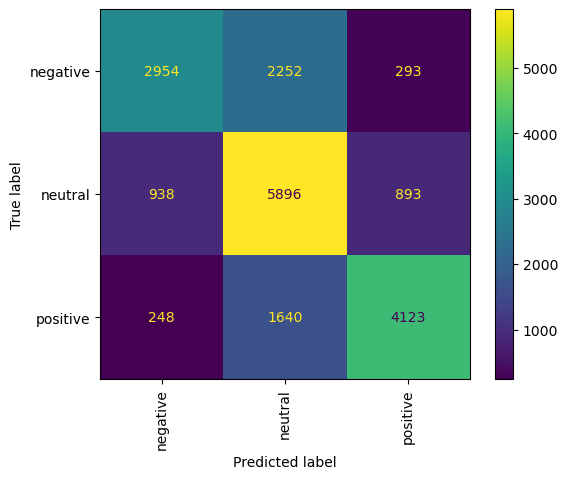

In [166]:
#PARAMETROS
#######################################
lista_palabras = ["not","best","big",'good', 'goods', 'got', 'great',
                 "new",'nobody','number','possible','small','well']
stopwords2 = [word for word in stopwords if word not in lista_palabras]
# stopwords2.extend(['this', 'else', 'then', 're'])

params_model={"max_iter":1000}
params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300}

lista_funciones = []

#MODELO
#######################################

preprocesador = Preprocesador_datos(X,"text",stopwords2)
# preprocesador._add_fc(cambio_contracciones)
preprocesador._add_fc(emoticonos2text_v2)

preprocesador.fit()
df_texto = preprocesador.datos_procesado


sv_ = Sentiment_Vectorizer(params_Tfidf )
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)

se_ = Sentiment_Evaluator(model = LogisticRegression,params_model=params_model)


if len(lista_funciones)>0:
    
    nfp = New_features_pruebas(X["text"], lista_funciones)
    df_new_features = nfp.obtener_variables()
    df_to_train = pd.concat([x___,df_new_features.reset_index()],axis=1).set_index("textID")
    columnas_finales = df_to_train.columns.tolist()
else:
    columnas_finales = x___.columns
    df_to_train = x___.copy()

N3_set = set(x___.columns.tolist())

#ENTRANAMIENTO
se_.fit(df_to_train,Y)

#RESULTADOS
se_.mostrar_tabla(df_to_train,Y)
se_.print_cv_results()

In [146]:
columns_analysis(set1= N2_set,set2= N3_set)

Numero de elementos  set1 300
Numero de elementos set2 300

Elementos que existen en set1 y no en set2:
{'hoping', 'news', 'internet'}
Elementos que existen en set2 y no en set1:
{'emotigood', 'com', 'rest'}


In [168]:
def coeficientes_modelo(columnas_finales, se_):
    df_resultados = pd.DataFrame({"palabras": columnas_finales,"coef_nega":list(se_.model.coef_[0]),"coef_neutral":list(se_.model.coef_[1]),"coef_pos":list(se_.model.coef_[2])})
    df_resultados.set_index('palabras',inplace=True)
    return df_resultados
coeficientes_modelo(columnas_finales, se_)

,coef_nega,coef_neutral,coef_pos
palabras,,,
10,-0.207059,-0.189308,0.396367
30,0.592063,-0.444031,-0.148033
actually,-0.266550,-0.016837,0.283388
ago,0.386196,-0.147322,-0.238874
am,0.543312,-0.298883,-0.244429
...,...,...,...
yay,-1.543441,-0.420881,1.964323
yeah,-0.131209,0.162437,-0.031228
yes,-0.656257,0.036937,0.619320


# ITERACION 4 revision coeficientes y revision dataset
Hay muchos datos negativos predichos como neutrales. Vamos a ver si podemos conseguir nuevas palabras mirando el dataset

In [172]:
def coeficientes_modelo(columnas_finales, se_):
    df_resultados = pd.DataFrame({"palabras": columnas_finales,"coef_nega":list(se_.model.coef_[0]),"coef_neutral":list(se_.model.coef_[1]),"coef_pos":list(se_.model.coef_[2])})
    df_resultados.set_index('palabras',inplace=True)

    df_resultados['abs_coef_nega'] = np.abs(df_resultados['coef_nega'])
    df_resultados['abs_coef_neutral'] = np.abs(df_resultados['coef_neutral'])
    df_resultados['abs_coef_pos'] = np.abs(df_resultados['coef_pos'])

    df_resultados['rank_coef_nega'] = df_resultados['abs_coef_nega'].rank(ascending=False).astype('int')
    df_resultados['rank_coef_neutral'] = df_resultados['abs_coef_neutral'].rank(ascending=False).astype('int')
    df_resultados['rank_coef_pos'] = df_resultados['abs_coef_pos'].rank(ascending=False).astype('int')
    return df_resultados

mod_coe = coeficientes_modelo(columnas_finales, se_)

In [327]:
mod_coe.loc["boy"]

coef_nega             -0.315840
coef_neutral           0.019775
coef_pos               0.296065
abs_coef_nega          0.315840
abs_coef_neutral       0.019775
abs_coef_pos           0.296065
rank_coef_nega       179.000000
rank_coef_neutral    290.000000
rank_coef_pos        189.000000
Name: boy, dtype: float64

In [330]:
mod_coe[['rank_coef_nega','rank_coef_neutral','rank_coef_pos']].apply(lambda x: min(x),axis=1).sort_values(ascending=False).head(35).index

Index(['gon', 'sun', 've', 'tweet', 'ticket', 'mine', 'home', 'idea', 'bed',
       'mind', 'little', 'cat', 'tv', 'school', 'minute', 'awake', 'stay',
       'money', 'else', 'if', 'doing', 'game', 'twitter', 'drive', 'time',
       'woke', 'kid', 'eat', 'try', 'probably', 'actually', 'girl', 'll',
       'iphone', 'guess'],
      dtype='object', name='palabras')

In [178]:
mod_coe[['coef_nega','abs_coef_nega','rank_coef_nega']].describe()

,coef_nega,abs_coef_nega,rank_coef_nega
count,300.000000,300.000000,300.000000
mean,-0.013317,0.673974,150.500000
std,0.993357,0.728818,86.746758
min,-3.206721,0.001654,1.000000
25%,-0.444662,0.203504,75.750000
50%,0.003269,0.418932,150.500000
75%,0.387945,0.792160,225.250000
max,3.668281,3.668281,300.000000


In [179]:
mod_coe[['coef_pos','abs_coef_pos','rank_coef_pos']].describe()

,coef_pos,abs_coef_pos,rank_coef_pos
count,300.000000,300.000000,300.000000
mean,0.270060,0.718771,150.500000
std,1.052582,0.814092,86.746758
min,-3.167138,0.000389,1.000000
25%,-0.240262,0.224805,75.750000
50%,0.222544,0.430578,150.500000
75%,0.553266,0.790072,225.250000
max,3.946231,3.946231,300.000000


Mirando las distribuciones de modelos positivos y negativos. La unica diferencia seria que el positivo tiene algunos terminos el cuartil superior que la distribución negativa no tiene.

In [180]:
mod_coe[['coef_neutral','abs_coef_neutral','rank_coef_neutral']].describe()

,coef_neutral,abs_coef_neutral,rank_coef_neutral
count,300.000000,300.000000,300.000000
mean,-0.256742,0.343815,150.500000
std,0.391577,0.317593,86.746758
min,-1.554820,0.000760,1.000000
25%,-0.487250,0.110551,75.750000
50%,-0.189591,0.243286,150.500000
75%,0.036244,0.501342,225.250000
max,0.563331,1.554820,300.000000


In [181]:
#Busqueda terminos

In [ ]:
se_.model.fit(df_to_train,Y)
y_predict = se_.model.predict(df_to_train)
y_predict = pd.Series(y_predict, name= "predicciones", index=Y.index)

dfa = pd.concat([Y,y_predict,X["text"],df_texto],axis=1)

sample_mn = dfa.query("sentiment=='negative' and predicciones=='neutral'").sample(35)

In [211]:
sample_mn

,sentiment,predicciones,text,texto
textID,,,,
6bd516748c,negative,neutral,reyt fancies a valentinos. Worst of times cons...,reyt fancy valentinos . worst time considering...
78717dbb3c,negative,neutral,wants New Moon. AHH Im going crazy.,new moon . ahh im crazy .
a979977b59,negative,neutral,http://twitpic.com/66ydb - I made sure you go...,weburl - i you got credit book ... i ` i forgo...
447dc22c81,negative,neutral,hemp cloth is marvelous but unfortunately no,hemp cloth marvelous unfortunately
f09ad7baef,negative,neutral,found out my 'friend' isnt actually. but hey *...,found 'friend ' isnt actually . hey * * * * ha...
203930da05,negative,neutral,Maybe if we pass a lay making the #swineflu i...,"maybe if pas lay # swineflu illegal , law abid..."
d614edff9e,negative,neutral,I would but I`m afraid I got two left feet,i i ` afraid i got left foot
7b21362baa,negative,neutral,"the next 2 weeks, exam wise, are AWFUL. there ...","2 week , exam wise , awful . 8 exam i don ` i ..."
c2e7f4c4d3,negative,neutral,my pooooor baby (my dog chachi) she had surge...,pooooor baby ( dog chachi ) surgery todayyyyy


In [259]:
sample_mn

,sentiment,predicciones,text,texto
textID,,,,
6bd516748c,negative,neutral,reyt fancies a valentinos. Worst of times cons...,reyt fancy valentinos . worst time considering...
78717dbb3c,negative,neutral,wants New Moon. AHH Im going crazy.,new moon . ahh im crazy .
a979977b59,negative,neutral,http://twitpic.com/66ydb - I made sure you go...,weburl - i you got credit book ... i ` i forgo...
447dc22c81,negative,neutral,hemp cloth is marvelous but unfortunately no,hemp cloth marvelous unfortunately
f09ad7baef,negative,neutral,found out my 'friend' isnt actually. but hey *...,found 'friend ' isnt actually . hey * * * * ha...
203930da05,negative,neutral,Maybe if we pass a lay making the #swineflu i...,"maybe if pas lay # swineflu illegal , law abid..."
d614edff9e,negative,neutral,I would but I`m afraid I got two left feet,i i ` afraid i got left foot
7b21362baa,negative,neutral,"the next 2 weeks, exam wise, are AWFUL. there ...","2 week , exam wise , awful . 8 exam i don ` i ..."
c2e7f4c4d3,negative,neutral,my pooooor baby (my dog chachi) she had surge...,pooooor baby ( dog chachi ) surgery todayyyyy


POSIBLES NUEVOS TERMINOS:


worst,worse, mad, , going crazy, cant have any,marvelous ,****
    I don`t see how
won`t get it
my pooooor
downfall 
sick 
gone out the window too  bit gutted.
didn`t
blocked 
can`t even
can`t get
always
What a dreary, rainy, crappy day.
boring
nothing fair
depressing
dont hav
UGHHH!!!

Me he fijado quito "no,going,cant removed"  
Voy a quitarlas de la lista de stopwords

# ITERACCION 5: 
    ITERACCION 3
    
    PREPROCESAMIENTO
    - funciones de contracciones : limpiar el texto que slang
    - f_replace : me he fijado que esto lo usa mucho la gente para evitar reglas anti-palabrotas
    - añadir terminos negativos
    - quitar palabras de stopwords
    
RESULTADO:
   0.657 -> 0.666

In [2]:

def cambio_contracciones(tweet):
    """ limpiar el texto  de slang"""
    re_repl = {
     r"\br\b": "are",
     r"\bu\b": "you",
     r"\bhaha\b": "ha",
     r"\bhahaha\b": "ha",
     r"\bdon`t\b": "do not",
     r"\bdoesn`t\b": "does not",
     r"\bdidn`t\b": "did not",
     r"\bhasn`t\b": "has not",
     r"\bhaven`t\b": "have not",
     r"\bhadn`t\b": "had not",
     r"\bwon`t\b": "wont",
     r"\bwouldn`t\b": "would not",
     r"\bcan`t\b": "cant",
     r"\bcan` t\b": "cant",
     r"\bcannot\b": "cant",
     r"\bI`m\b": "Im",
     r"\bI` m\b": "Im",
     r"\bI am\b": "Im", 
     r"\bUGHHH*\b": "ugh", 
     r"\b[Uu]gh*\b": "ugh", 
     r"\b`ve\b": " have" #, 
     # r"****":"fuck"
        
        
     }
    for r, repl in re_repl.items():
     tweet = re.sub(r, repl, tweet)
    return tweet


def f_replace(text):
    
    text = text.replace("****","fuck")
    return text

In [299]:
base_tfidf = ['feeling',
 'lol',
 'picture',
 'playing',
 'rock',
 'eating',
 'hope',
 'forgot',
 'song',
 'photo',
 'fuck',
 'drive',
 'ah',
 'funny',
 'late',
 'phone',
 'coffee',
 'office',
 'waiting',
 'hot',
 'computer',
 'time',
 'minute',
 'tho',
 'cat',
 'twitter',
 'ugh',
 'wish',
 'hopefully',
 'doing',
 'saturday',
 'kid',
 'mean',
 'site',
 'yes',
 'follower',
 'rest',
 'trip',
 'lot',
 'fan',
 'game',
 'internet',
 'read',
 'stuff',
 'friend',
 'getting',
 'good',
 'run',
 'great',
 'missing',
 'check',
 'fun',
 'headache',
 '10',
 'head',
 'real',
 'called',
 'best',
 'cant',
 'im',
 'wrong',
 'trying',
 'forward',
 'beautiful',
 'believe',
 'looking',
 'play',
 'heard',
 'mom',
 're',
 'sorry',
 'look',
 'super',
 'anymore',
 'money',
 'woke',
 'tv',
 'facebook',
 'star',
 'well',
 'hit',
 'house',
 'hoping',
 'love',
 'brother',
 'night',
 'oh',
 'seeing',
 'seen',
 'gone',
 'hour',
 'please',
 'talk',
 'dad',
 'stupid',
 'summer',
 'buy',
 'couldn',
 'girl',
 'boy',
 'own',
 'wa',
 'free',
 'ago',
 'awesome',
 'book',
 'bit',
 'weburl',
 'awww',
 'war',
 'big',
 'leave',
 'cool',
 'gon',
 'lost',
 'lady',
 'nice',
 '30',
 'lmao',
 'stuck',
 'yeah',
 'sunday',
 'cry',
 'dream',
 'thanks',
 'maybe',
 'enjoy',
 'dog',
 'wow',
 'bad',
 'day',
 'guy',
 'following',
 'person',
 'bed',
 'weather',
 'amazing',
 'online',
 'else',
 'cute',
 'miss',
 'movie',
 'wonderful',
 'dude',
 'job',
 'home',
 'class',
 'outside',
 'month',
 'aww',
 'start',
 'iphone',
 'word',
 'not',
 'goodnight',
 'meet',
 'ticket',
 'new',
 'try',
 'talking',
 'world',
 'win',
 'busy',
 'crazy',
 'sleep',
 'watch',
 'thats',
 'hurt',
 'happy',
 'ill',
 'le',
 'mine',
 'starting',
 'dinner',
 'idea',
 'actually',
 'people',
 'got',
 'name',
 'omg',
 'am',
 'hug',
 'lovely',
 'exam',
 'tell',
 'watching',
 'loved',
 'stay',
 'coming',
 'monday',
 'taking',
 'mommy',
 'follow',
 'drink',
 'listening',
 'holiday',
 'mother',
 'food',
 'sound',
 'car',
 'cause',
 'morning',
 'soon',
 'hear',
 'birthday',
 'ur',
 'lunch',
 'hard',
 'tried',
 'feel',
 'didnt',
 'doe',
 'thank',
 'god',
 'tired',
 'party',
 'till',
 'mum',
 'left',
 'friday',
 'live',
 'stop',
 'family',
 'thinking',
 'mind',
 'excited',
 'plan',
 'sun',
 'hair',
 'welcome',
 'kinda',
 'shopping',
 'suck',
 'post',
 'found',
 'hi',
 'yay',
 'totally',
 'cold',
 'week',
 'sweet',
 'ta',
 'news',
 'wan',
 'awake',
 'rain',
 'weekend',
 'baby',
 'hey',
 'school',
 'pic',
 'hello',
 'sad',
 'finally',
 'wait',
 'na',
 'eat',
 'isn',
 'boo',
 'eye',
 'tomorrow',
 'bored',
 'hell',
 'probably',
 'life',
 'if',
 'ya',
 'you',
 'missed',
 'broke',
 'ha',
 'instead',
 'music',
 'finished',
 'yesterday',
 'trek',
 'this',
 'luck',
 'pretty',
 'll',
 'wasn',
 'video',
 'com',
 'then',
 'ok',
 'tweet',
 'dont',
 'break',
 'poor',
 'okay',
 'guess',
 'glad',
 'hate',
 'help',
 'little',
 'sooo',
 'sick',
 'call',
 'tonight',
 'ready']

In [355]:
terminos_inutiles = ['gon', 'sun', 've', 'tweet', 'ticket', 'mine', 'home', 'idea', 'bed',
       'mind', 'little', 'cat', 'tv', 'school', 'minute', 'awake', 'stay',
       'money', 'else', 'if', 'doing', 'game', 'twitter', 'drive', 'time',
       'woke', 'kid', 'eat', 'try', 'probably', 'actually', 'girl', 'll',
       'iphone', 'guess']

In [357]:
variables_tfidf_aux = base_tfidf +["fair","downfall","gutted"]+ ["dreary", "rainy", "crappy"]+["boring","depressing"]

variables_tfidf = [w for w in variables_tfidf_aux if w not in terminos_inutiles]

              precision    recall  f1-score   support

    negative       0.71      0.57      0.63      5499
     neutral       0.61      0.76      0.68      7727
    positive       0.78      0.69      0.73      6011

    accuracy                           0.68     19237
   macro avg       0.70      0.67      0.68     19237
weighted avg       0.69      0.68      0.68     19237

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.666
std:0.008
min:0.650
max:0.679


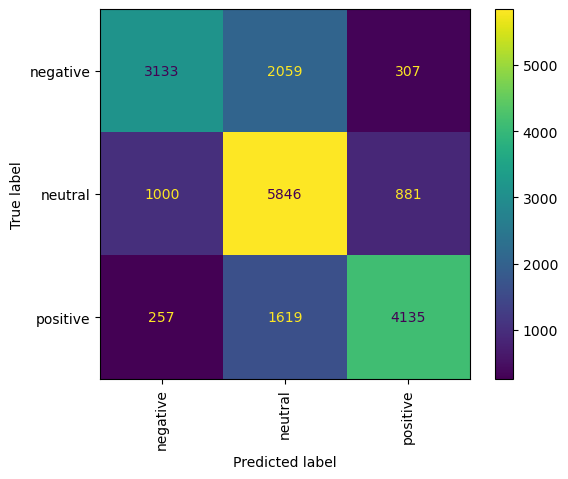

In [359]:
#PARAMETROS
#######################################
lista_palabras = ["not","best","big",'good', 'goods', 'got', 'great',
                 "new",'nobody','number','possible','small','well', "going"]
stopwords2 = [word for word in stopwords if word not in lista_palabras]
# stopwords2.extend(['this', 'else', 'then', 're'])
stopwords2.extend(terminos_inutiles)
params_model={"max_iter":1000}

params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300,
                        "vocabulary":variables_tfidf
               }

lista_funciones = []

#MODELO
#######################################

preprocesador = Preprocesador_datos(X,"text",stopwords2)
preprocesador._add_fc(cambio_contracciones)
preprocesador._add_fc(f_replace)


preprocesador.fit()
df_texto = preprocesador.datos_procesado


sv_ = Sentiment_Vectorizer(params_Tfidf )
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)

se_ = Sentiment_Evaluator(model = LogisticRegression,params_model=params_model)


if len(lista_funciones)>0:
    
    nfp = New_features_pruebas(X["text"], lista_funciones)
    df_new_features = nfp.obtener_variables()
    df_to_train = pd.concat([x___,df_new_features.reset_index()],axis=1).set_index("textID")
    columnas_finales = df_to_train.columns.tolist()
else:
    columnas_finales = x___.columns
    df_to_train = x___.copy()

N4_set = set(x___.columns.tolist())

#ENTRANAMIENTO
se_.fit(df_to_train,Y)

#RESULTADOS
se_.mostrar_tabla(df_to_train,Y)
se_.print_cv_results()

# ITERACCION 6  
    - ITERACCION 5
    
    - ptos suspensivos
    - exclamaciones
    

RESULTADO 
0.666 -> 0.671

In [8]:
base = ['feeling',
 'lol',
 'picture',
 'playing',
 'rock',
 'eating',
 'hope',
 'forgot',
 'song',
 'photo',
 'fuck',
 'ah',
 'funny',
 'late',
 'phone',
 'coffee',
 'office',
 'waiting',
 'hot',
 'computer',
 'tho',
 'ugh',
 'wish',
 'hopefully',
 'saturday',
 'mean',
 'site',
 'yes',
 'follower',
 'rest',
 'trip',
 'lot',
 'fan',
 'internet',
 'read',
 'stuff',
 'friend',
 'getting',
 'good',
 'run',
 'great',
 'missing',
 'check',
 'fun',
 'headache',
 '10',
 'head',
 'real',
 'called',
 'best',
 'cant',
 'im',
 'wrong',
 'trying',
 'forward',
 'beautiful',
 'believe',
 'looking',
 'play',
 'heard',
 'mom',
 're',
 'sorry',
 'look',
 'super',
 'anymore',
 'facebook',
 'star',
 'well',
 'hit',
 'house',
 'hoping',
 'love',
 'brother',
 'night',
 'oh',
 'seeing',
 'seen',
 'gone',
 'hour',
 'please',
 'talk',
 'dad',
 'stupid',
 'summer',
 'buy',
 'couldn',
 'boy',
 'own',
 'wa',
 'free',
 'ago',
 'awesome',
 'book',
 'bit',
 'weburl',
 'awww',
 'war',
 'big',
 'leave',
 'cool',
 'lost',
 'lady',
 'nice',
 '30',
 'lmao',
 'stuck',
 'yeah',
 'sunday',
 'cry',
 'dream',
 'thanks',
 'maybe',
 'enjoy',
 'dog',
 'wow',
 'bad',
 'day',
 'guy',
 'following',
 'person',
 'weather',
 'amazing',
 'online',
 'cute',
 'miss',
 'movie',
 'wonderful',
 'dude',
 'job',
 'class',
 'outside',
 'month',
 'aww',
 'start',
 'word',
 'not',
 'goodnight',
 'meet',
 'new',
 'talking',
 'world',
 'win',
 'busy',
 'crazy',
 'sleep',
 'watch',
 'thats',
 'hurt',
 'happy',
 'ill',
 'le',
 'starting',
 'dinner',
 'people',
 'got',
 'name',
 'omg',
 'am',
 'hug',
 'lovely',
 'exam',
 'tell',
 'watching',
 'loved',
 'coming',
 'monday',
 'taking',
 'mommy',
 'follow',
 'drink',
 'listening',
 'holiday',
 'mother',
 'food',
 'sound',
 'car',
 'cause',
 'morning',
 'soon',
 'hear',
 'birthday',
 'ur',
 'lunch',
 'hard',
 'tried',
 'feel',
 'didnt',
 'doe',
 'thank',
 'god',
 'tired',
 'party',
 'till',
 'mum',
 'left',
 'friday',
 'live',
 'stop',
 'family',
 'thinking',
 'excited',
 'plan',
 'hair',
 'welcome',
 'kinda',
 'shopping',
 'suck',
 'post',
 'found',
 'hi',
 'yay',
 'totally',
 'cold',
 'week',
 'sweet',
 'ta',
 'news',
 'wan',
 'rain',
 'weekend',
 'baby',
 'hey',
 'pic',
 'hello',
 'sad',
 'finally',
 'wait',
 'na',
 'isn',
 'boo',
 'eye',
 'tomorrow',
 'bored',
 'hell',
 'life',
 'ya',
 'you',
 'missed',
 'broke',
 'ha',
 'instead',
 'music',
 'finished',
 'yesterday',
 'trek',
 'this',
 'luck',
 'pretty',
 'wasn',
 'video',
 'com',
 'then',
 'ok',
 'dont',
 'break',
 'poor',
 'okay',
 'glad',
 'hate',
 'help',
 'sooo',
 'sick',
 'call',
 'tonight',
 'ready',
 'fair',
 'downfall',
 'gutted',
 'dreary',
 'rainy',
 'crappy',
 'boring',
 'depressing']

In [48]:
variables_tfidf_aux = base.copy()
new=[] #basura
old_new = ["disappointing","tough","weird","angry","lame","so","expensive","stressed","honest","sadly","sucked"]
variables_tfidf_aux2 = variables_tfidf_aux + old_new+ new
terminos_inutiles =   []
variables_tfidf = [w for w in variables_tfidf_aux2 if w not in terminos_inutiles]

In [49]:
variables_tfidf

['feeling',
 'lol',
 'picture',
 'playing',
 'rock',
 'eating',
 'hope',
 'forgot',
 'song',
 'photo',
 'fuck',
 'ah',
 'funny',
 'late',
 'phone',
 'coffee',
 'office',
 'waiting',
 'hot',
 'computer',
 'tho',
 'ugh',
 'wish',
 'hopefully',
 'saturday',
 'mean',
 'site',
 'yes',
 'follower',
 'rest',
 'trip',
 'lot',
 'fan',
 'internet',
 'read',
 'stuff',
 'friend',
 'getting',
 'good',
 'run',
 'great',
 'missing',
 'check',
 'fun',
 'headache',
 '10',
 'head',
 'real',
 'called',
 'best',
 'cant',
 'im',
 'wrong',
 'trying',
 'forward',
 'beautiful',
 'believe',
 'looking',
 'play',
 'heard',
 'mom',
 're',
 'sorry',
 'look',
 'super',
 'anymore',
 'facebook',
 'star',
 'well',
 'hit',
 'house',
 'hoping',
 'love',
 'brother',
 'night',
 'oh',
 'seeing',
 'seen',
 'gone',
 'hour',
 'please',
 'talk',
 'dad',
 'stupid',
 'summer',
 'buy',
 'couldn',
 'boy',
 'own',
 'wa',
 'free',
 'ago',
 'awesome',
 'book',
 'bit',
 'weburl',
 'awww',
 'war',
 'big',
 'leave',
 'cool',
 'lost',
 '

In [220]:
# new=["screw","careful","expensive","stressed","home","estimate","kind","honest","sadly","date","sucked"]
[w for w in new if w  in stopwords2]

[]

In [46]:
def cambio_contracciones(tweet):
    
    re_repl = {
     r"\br\b": "are",
     r"\bu\b": "you",
     r"\bhaha\b": "ha",
     r"\bhahaha\b": "ha",
     r"\bdon`t\b": "do not",
     r"\bdoesn`t\b": "does not",
     r"\bdidn`t\b": "did not",
     r"\bhasn`t\b": "has not",
     r"\bhaven`t\b": "have not",
     r"\bhadn`t\b": "had not",
     r"\bwon`t\b": "wont",
     r"\bwouldn`t\b": "would not",
     r"\bcan`t\b": "cant",
     r"\bcan` t\b": "cant",
     r"\bcannot\b": "cant",
     r"\bI`m\b": "Im",
     r"\bI` m\b": "Im",
     r"\bI am\b": "Im", 
     r"\bUGHHH*\b": "ugh", 
     r"\b[Uu]gh*\b": "ugh",
     r"\bI` ve\b": "I have",  
     r"\b[Ii]` s\b": "it is ",
     r"\b[Ii]`s\b": "it is ",
     r"\bborin\b": "boring",  
     r"\bple+a+se\b": "please",  
     r"in`": "ing",  
     r"\bso+\b": "so", 
     r"\bso+w+y+\b": "sorry", 
     r"\b\#\w*\b": "hastag",
     r"[Yy]outube":" socialnetwork ",
     r"myspace":" socialnetwork ",
     r"twitpic":" socialnetwork ",
        r"latalkradio":" socialnetwork ",
        r"[Tt]witter":" socialnetwork ",
     r"[Tt]witch":" socialnetwork ",
     r"\b: -\\/\b":"emosad",
        "#\w*":"topico",
     r"\b` ve\b": " have "}
    for r, repl in re_repl.items():
     tweet = re.sub(r, repl, tweet)
    return tweet


def f_replace(text):
    
    text = text.replace("****","fuck")
    return text
    

<>:40: SyntaxWarning: invalid escape sequence '\w'
<>:40: SyntaxWarning: invalid escape sequence '\w'
C:\Users\x136711\AppData\Local\Temp\ipykernel_18904\173068982.py:40: SyntaxWarning: invalid escape sequence '\w'
  "#\w*":"topico",


In [14]:
def conteo_ptos_suspensivos(ss):
    return len(re.findall("...",ss.lower() ))
def conteo_exclamaciones(ss):
    return len(re.findall("!",ss.lower() ))

def conteo_poor(ss):
    return len(re.findall("poo+r",ss.lower() ))

def conteo_palabras(ss):
    return len(ss.split())
    

C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy arra

              precision    recall  f1-score   support

    negative       0.72      0.58      0.64      5499
     neutral       0.62      0.76      0.68      7727
    positive       0.78      0.69      0.73      6011

    accuracy                           0.69     19237
   macro avg       0.70      0.68      0.68     19237
weighted avg       0.70      0.69      0.69     19237

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.671
std:0.009
min:0.653
max:0.685


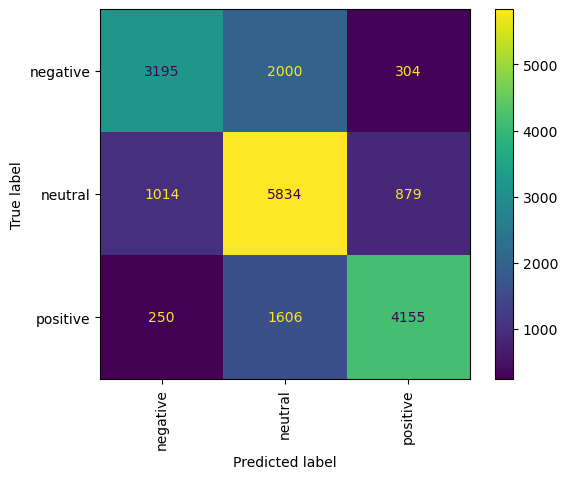

In [42]:
#PARAMETROS
#######################################
lista_palabras = ["not","best","big",'good', 'goods', 'got', 'great',
                 "new",'nobody','number','possible','small',"kind",'well', "going","but","find","so","much"]
stopwords2 = [word for word in stopwords if word not in lista_palabras]
# stopwords2.extend(['this', 'else', 'then', 're'])
stopwords2.extend(terminos_inutiles)
params_model={"max_iter":2000}

params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300,
                        "vocabulary":variables_tfidf
               }

lista_funciones = [("conteo_exclamaciones",conteo_exclamaciones),
                   #("conteo_palabras",conteo_palabras),
                   #("conteo_poor",conteo_poor),
                  ("conteo_ptos_suspensivos",conteo_ptos_suspensivos)
                  ]

#MODELO
#######################################

preprocesador = Preprocesador_datos(X,"text",stopwords2)
preprocesador._add_fc(cambio_contracciones)
preprocesador._add_fc(f_replace)


preprocesador.fit()
df_texto = preprocesador.datos_procesado


sv_ = Sentiment_Vectorizer(params_Tfidf )
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)

params_Tfidf_2 = {"ngram_range":(2, 2), 
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":20,
                  "vocabulary": ["getting hungry","make shows","too big" ] #basura
               }
sv_2 = Sentiment_Vectorizer(params_Tfidf_2 )
x___2 = sv_2.fit_transform_vectorizer(preprocesador.datos_procesado)



se_ = Sentiment_Evaluator(model = LogisticRegression,params_model=params_model)


if len(lista_funciones)>0:
    
    nfp = New_features_pruebas(X["text"], lista_funciones)
    df_new_features = nfp.obtener_variables()
    df_to_train = pd.concat([x___,x___2,df_new_features.reset_index()],axis=1).set_index("textID")
    columnas_finales = df_to_train.columns.tolist()
else:
    columnas_finales = x___.columns
    df_to_train = x___.copy()

N4_set = set(x___.columns.tolist())

#ENTRANAMIENTO
se_.fit(df_to_train,Y)

#RESULTADOS
se_.mostrar_tabla(df_to_train,Y)
se_.print_cv_results()

In [44]:
def coeficientes_modelo(columnas_finales, se_):
    df_resultados = pd.DataFrame({"palabras": columnas_finales,"coef_nega":list(se_.model.coef_[0]),"coef_neutral":list(se_.model.coef_[1]),"coef_pos":list(se_.model.coef_[2])})
    df_resultados.set_index('palabras',inplace=True)

    df_resultados['abs_coef_nega'] = np.abs(df_resultados['coef_nega'])
    df_resultados['abs_coef_neutral'] = np.abs(df_resultados['coef_neutral'])
    df_resultados['abs_coef_pos'] = np.abs(df_resultados['coef_pos'])

    df_resultados['rank_coef_nega'] = df_resultados['abs_coef_nega'].rank(ascending=False).astype('int')
    df_resultados['rank_coef_neutral'] = df_resultados['abs_coef_neutral'].rank(ascending=False).astype('int')
    df_resultados['rank_coef_pos'] = df_resultados['abs_coef_pos'].rank(ascending=False).astype('int')
    return df_resultados

mod_coe = coeficientes_modelo(columnas_finales, se_)

In [45]:
mod_coe.loc[new]

,coef_nega,coef_neutral,coef_pos,abs_coef_nega,abs_coef_neutral,abs_coef_pos,rank_coef_nega,rank_coef_neutral,rank_coef_pos
palabras,,,,,,,,,
socialnetwork,-0.132421,-0.074514,0.206935,0.132421,0.074514,0.206935,250,249,237


In [20]:
se_.model.fit(df_to_train,Y)
y_predict = se_.model.predict(df_to_train)
y_predict = pd.Series(y_predict, name= "predicciones", index=Y.index)

dfa = pd.concat([Y,y_predict,X["text"],df_texto],axis=1)

C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
#buscamos nuevos terminos en el dataset

In [165]:
sample_mn = dfa.query("sentiment=='negative' and predicciones=='neutral'").sample(35)
# sample_mn

In [184]:
i=5*7
for l,text in sample_mn[["text"]].iloc[(0+i):(5+i)].iterrows():
    print(text['text'])

In [183]:
f = i+5
for j,row in  sample_mn["texto"][i:f].items():
    print(row)

well then andy i dont you date
indeed , fail
normal this morning , got attacked swarm mini fly ` veranda night hour rid ! !
horrible twitter-er . moved houston apartment awaiting starting monday . real world=now
well sucked except company i . kelly .
